# Selecting Central Jets

To work we need a ServiceX instance to run against. For this demo we'll use the Open Data instance located at University of Nebraska.

All ServiceX instances require an account. To get an account go to [https://coffea-opendata.casa/](https://coffea-opendata.casa/), log in, and wait to be approved.

## Stream of Events (Source)

Most commonly called the dataset - it specifies the source we will be pulling from. 

For this simple demo, lets do a single file on an open link, at an `http` endpoint. This is the first `ttbar` file from the `analysis-grand-challenge` [master ntuple list](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/ntuples.json).

In [1]:
from func_adl_servicex import ServiceXSourceUpROOT

file ="https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root"

ds = ServiceXSourceUpROOT([file], treename="events")

`ds`, short for dataset, is the stream of events source. Since this is a column wise ntuple, and `ds` gives us access to its contents. We are going to have to make a cut on jet $p_T$ - so lets get that first

In [2]:
data = (ds
    .Select(lambda e: {
        'pt': e.jet_pt,
    })
    .AsAwkwardArray()
    .value()
)

Now we will make a hist using the standard plotting tools. I'm from ATLAS, even though this isn't ATLAS data, I'll use the standard format for ATLAS.

In [3]:
import mplhep as hep
hep.style.use(hep.style.ATLAS)
# _ = hep.atlas.label("Personal", data=False)

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


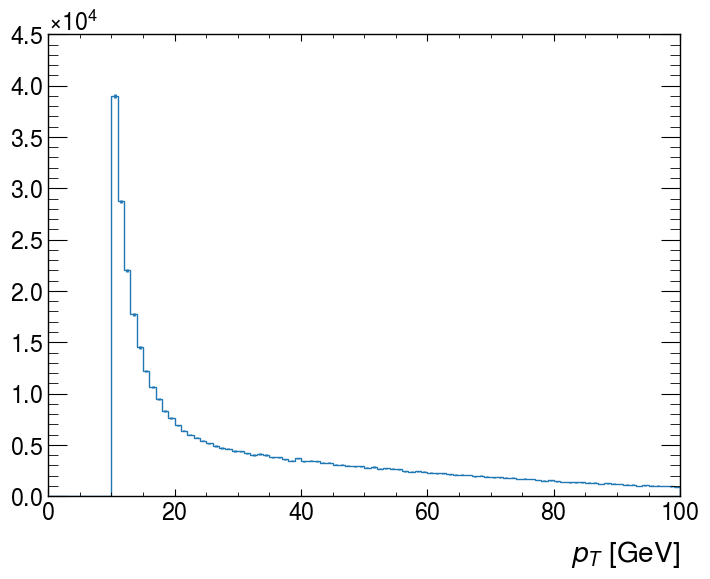

In [4]:
import awkward as ak
from hist import Hist
import matplotlib.pyplot as plt

h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_T$ [GeV]")
  .Int64()
)
h.fill(ak.flatten(data.pt))
h.plot()
plt.show()

We now have $p_T$ as a very simple variable. The goal is to cut on $p_T$ and $\eta$ and then grab $p_x, p_y$, and $p_z$. The first thing we want to do is cut on $p_T$ and $\eta$.

The tuples we are reading from here are column-wise. So we need to establish a relationship between the $p_T$, the $\eta$ and the momentum components. We use `zip` to do that. Once that is done, we can treat things as even-wise, even though we are actually operating column wise. This makes it a lot easier to think about! Since it is much easier to refer to things by name, we use a dictionary to do that, and a special version of `Zip` to make them work event-by-event:

In [5]:
edm = (ds
    .Select(lambda e: {
        'pT': e.jet_pt,
        'eta': e.jet_eta,
        'px': e.jet_px,
        'py': e.jet_py,
        'pz': e.jet_pz,
    }.Zip())
)

Next, we can cut on what we need:

In [6]:
filtered = (edm
    .SelectMany(lambda jets: jets)
    .Where(lambda j: j.pT > 30 and abs(j.eta) < 2.5)
)

And now we can extract the momentum components, and label them for when they come back as `awkward` arrays:

In [7]:
components = (filtered
    .Select(lambda j: {
        'px': j.px,
        'py': j.py,
        'pz': j.pz
    })
    .AsAwkwardArray()
    .value()
)

In [8]:
ak.type(components)

181014 * {"px": float32, "py": float32, "pz": float32}

In [9]:
ak.type(components.px)

181014 * float32

How can we verify this? We want to calculate $p_T$, but that is painful. Instead, lets use `vector` as we saw in the previous talk.

In [10]:
import vector
vector.register_awkward()

as_vector = ak.Array(components, with_name='Momentum3D')

In [11]:
as_vector

<MomentumArray3D [{px: 24.9, py: -93.3, ... pz: 8.34}] type='181014 * Momentum3D...'>

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


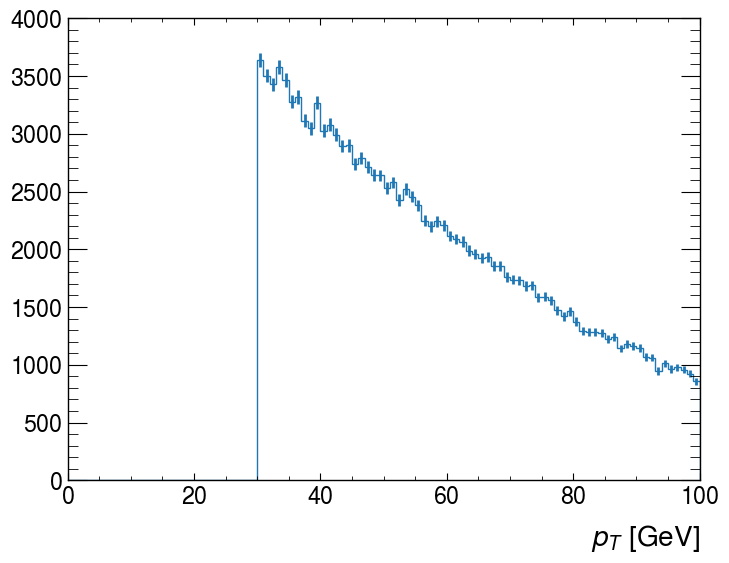

In [12]:
h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_T$ [GeV]")
  .Int64()
)
h.fill(as_vector.pt)
h.plot()
plt.show()

Of course, `servicex` likes to run on lots of files, not just one! So we need to fetch them all. In order to get at that, we need to load in the [`ntuples.json`](https://github.com/iris-hep/analysis-grand-challenge/blob/main/analyses/cms-open-data-ttbar/ntuples.json) file from github.

In [13]:
import urllib
import json

text = urllib.request.urlopen("https://github.com/iris-hep/analysis-grand-challenge/raw/main/analyses/cms-open-data-ttbar/ntuples.json").read()
ntuples = json.loads(text)

In [15]:
all_ttbar = [f['path'] for f in ntuples['ttbar']['nominal']['files']]
len(all_ttbar)

7066

And we can now re-create the code from above

In [20]:
def get_components(ds):
    edm = (ds
        .Select(lambda e: {
            'pT': e.jet_pt,
            'eta': e.jet_eta,
            'px': e.jet_px,
            'py': e.jet_py,
            'pz': e.jet_pz,
        }.Zip())
    )
    filtered = (edm
        .SelectMany(lambda jets: jets)
        .Where(lambda j: j.pT > 30 and abs(j.eta) < 2.5)
    )
    components = (filtered
        .Select(lambda j: {
            'px': j.px,
            'py': j.py,
            'pz': j.pz
        })
        .AsAwkwardArray()
        .value()
    )
    return components

In [21]:
ttbar = ServiceXSourceUpROOT(all_ttbar[:100], treename="events")
ttbar_components = get_components(ttbar)

The above line - took about one minute to execute (and over 10 minutes to download on this poor internet connection!)

In [22]:
ttbar_components

<Array [{px: 24.9, py: -93.3, ... pz: -5.71}] type='18945304 * {"px": float32, "...'>

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


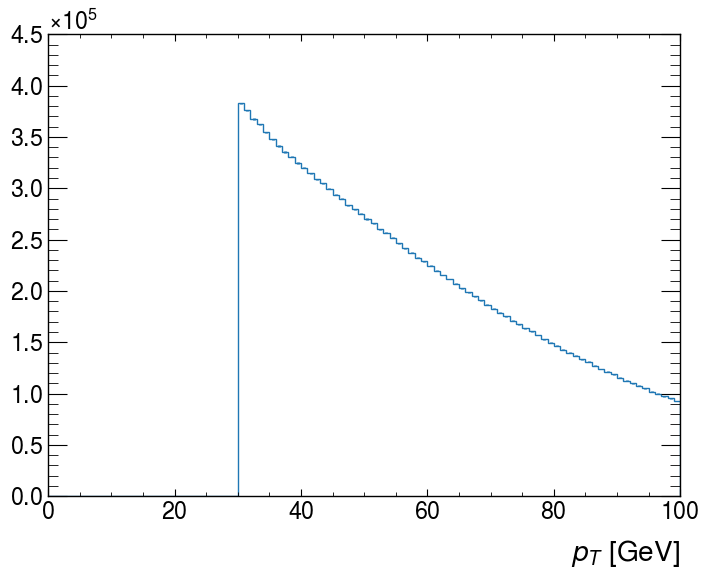

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


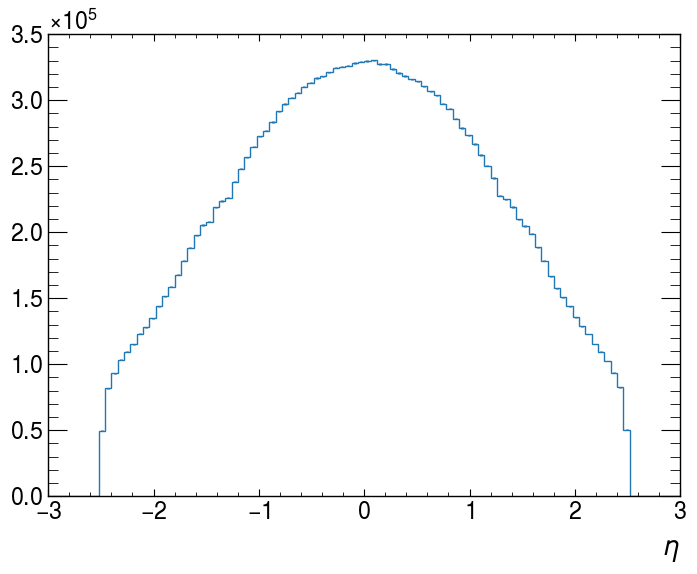

In [24]:
ttbar_vector = ak.Array(ttbar_components, with_name='Momentum3D')
h_pt = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_T$ [GeV]")
  .Int64()
)
h_pt.fill(ttbar_vector.pt)
h_pt.plot()
plt.show()

h_eta = (
  Hist.new
  .Reg(100, -3 , 3, name="eta", label=r"$\eta$")
  .Int64()
)
h_eta.fill(ttbar_vector.eta)
h_eta.plot()
plt.show()